In [6]:
import runner
import utils
import dataset
import dataclasses
import matlab.engine
import lstm_model
import reference_impl

## Bulk Test for various total Bit Levels

Saving files to  ../data/dataset2\train_set.pickle
Number of samples (13865, 1, 32, 1, 80)
Saving files to  ../data/dataset2\test_set.pickle
Number of samples (3086, 1, 32, 1, 80)
Running Model lstm, btot 16, pred_size 5
Noise is added to the test and train samples train snr 100.0 in linear , test snr 100.0 in linear
This is the LSTM
Fitting the PCA
Fitting the LSTM
Training k-means clustering...


  0%|          | 0/3 [00:00<?, ?it/s]

Predicted zdl: (3076, 200)
Predicted zdl: (3076, 200)
ul_pred_error: (3076, 200)
Assessing performance...
Plotting results...


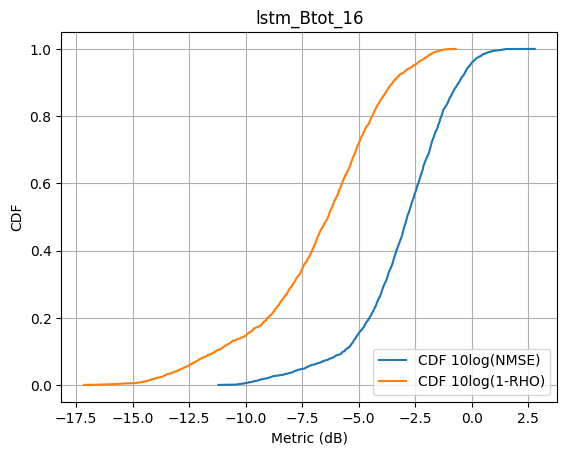

Test for lstm 16 complete!
Noise is added to the test and train samples train snr 100.0 in linear , test snr 100.0 in linear
Training k-means clustering...


  0%|          | 0/3 [00:00<?, ?it/s]

Assessing performance...
Plotting results...


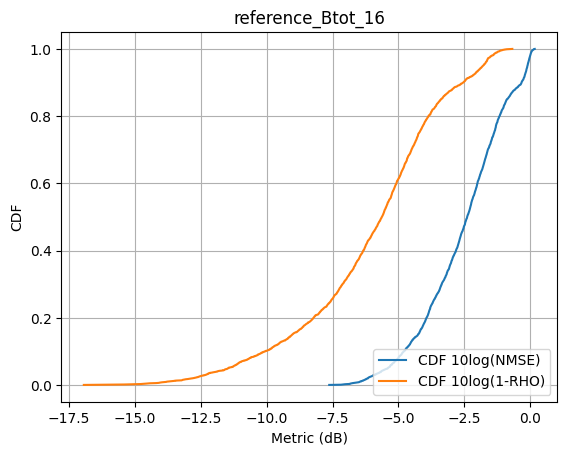

Running Model lstm, btot 32, pred_size 5
Noise is added to the test and train samples train snr 100.0 in linear , test snr 100.0 in linear
This is the LSTM
Fitting the PCA
Fitting the LSTM
Training k-means clustering...


  0%|          | 0/4 [00:00<?, ?it/s]

Predicted zdl: (3076, 200)
Predicted zdl: (3076, 200)
ul_pred_error: (3076, 200)
Assessing performance...
Plotting results...


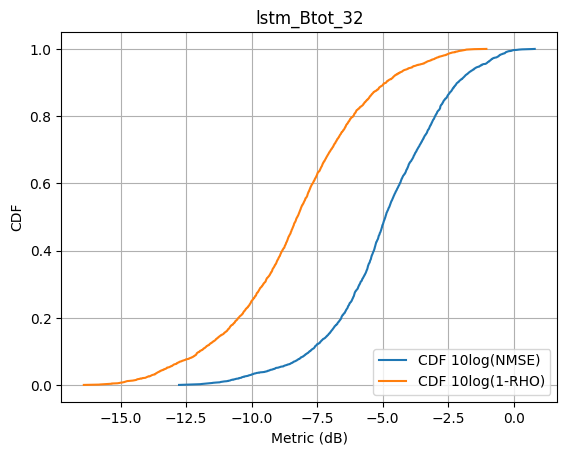

Test for lstm 32 complete!
Noise is added to the test and train samples train snr 100.0 in linear , test snr 100.0 in linear
Training k-means clustering...


  0%|          | 0/4 [00:00<?, ?it/s]

Assessing performance...
Plotting results...


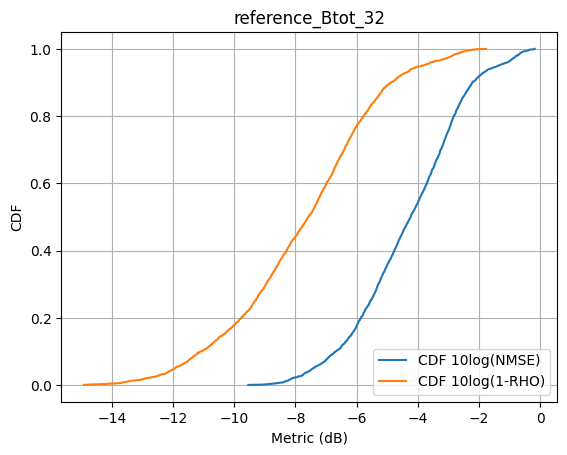

Running Model lstm, btot 128, pred_size 5
Noise is added to the test and train samples train snr 100.0 in linear , test snr 100.0 in linear
This is the LSTM
Fitting the PCA
Fitting the LSTM
Training k-means clustering...


  0%|          | 0/7 [00:00<?, ?it/s]

Predicted zdl: (3076, 200)
Predicted zdl: (3076, 200)
ul_pred_error: (3076, 200)
Assessing performance...
Plotting results...


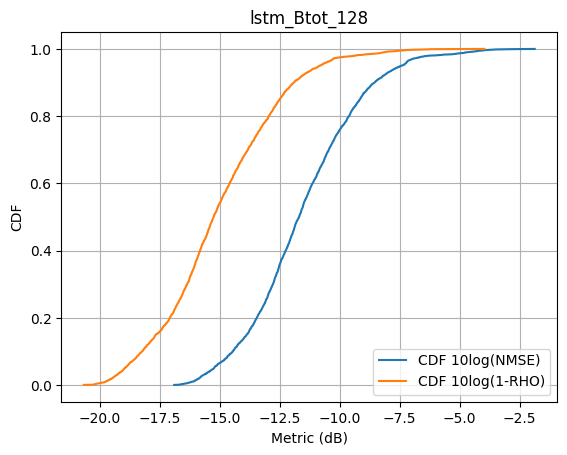

Test for lstm 128 complete!
Noise is added to the test and train samples train snr 100.0 in linear , test snr 100.0 in linear
Training k-means clustering...


  0%|          | 0/7 [00:00<?, ?it/s]

Assessing performance...
Plotting results...


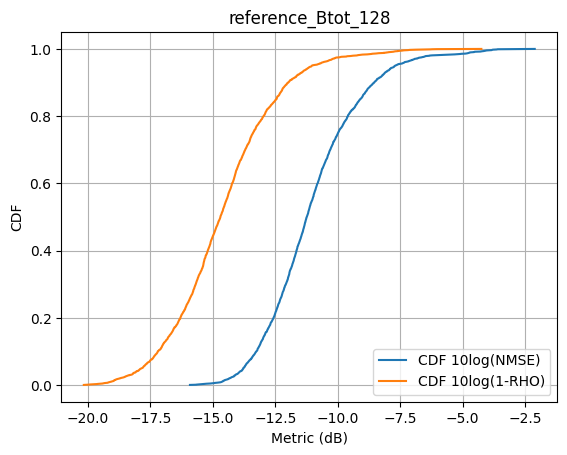

Running Model lstm, btot 512, pred_size 5
Noise is added to the test and train samples train snr 100.0 in linear , test snr 100.0 in linear
This is the LSTM
Fitting the PCA
Fitting the LSTM
Training k-means clustering...


  0%|          | 0/12 [00:00<?, ?it/s]

Predicted zdl: (3076, 200)
Predicted zdl: (3076, 200)
ul_pred_error: (3076, 200)
Assessing performance...
Plotting results...


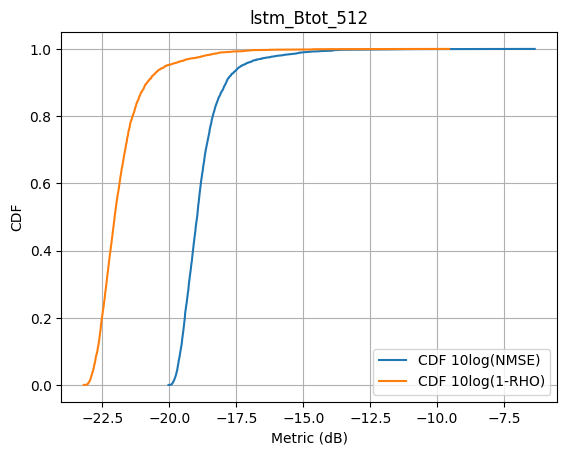

Test for lstm 512 complete!
Noise is added to the test and train samples train snr 100.0 in linear , test snr 100.0 in linear
Training k-means clustering...


  0%|          | 0/12 [00:00<?, ?it/s]

Assessing performance...
Plotting results...


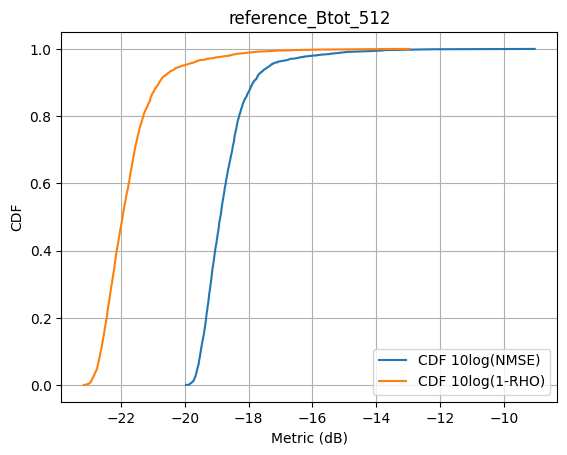

In [7]:
snrdb = 20
snr = 10**(snrdb/10)
windowsize = 5

cfg = utils.Config(
    num_rx_antennas=1,
    num_tx_antennas=32,
    num_subcarriers=80,
    train_test_split=0.8,
    data_root="../data/dataset2",
    reduce_pca_overhead=False,
    epochs=10,
    predictor_window_size = windowsize,
    total_bits=16,
    results_save_path=f"../results/trainsnr{snrdb}_testsnr{snrdb}_windowsize{windowsize}",
    compressor_type="kmeans",
    preprocessor_type="real_imag",
    trunc_lstm_pred=20,
    normalization_type="max",
    max_pca_coeffs=200,
    train_snr=snr, #no noise
    test_snr=snr, #no noise
    # duplicate_data=1,
    # data_snr=-1
)

dataset.combine_time_series_paths(
    cfg.data_root,
    list(range(32)),
    2.5e9,
    "train_set.pickle"
)
dataset.combine_time_series_paths(
    cfg.data_root,
    list(range(33,40)),
    2.62e9,
    "test_set.pickle")

matlab = matlab.engine.start_matlab()

possible_bits = [16,32,128,512]
for btot in possible_bits:
    this_cfg = dataclasses.replace(cfg, total_bits=btot)

    runner.run_model(
        this_cfg,
        matlab,
        lstm_model.FullLSTMModel,
        "lstm",
        # simulation=True   # Runs a full time series simulation during testing, ensuring realistic CSI histories. In practice we have found this does not affect performance, but takes much longer.
    )

    runner.run_reference_model(
        this_cfg,
        matlab,
        reference_impl.FullReferenceModel,
        "reference"
    )

## Big Test for many many combinations of SNR, Windowsize, Bits

In [8]:
click = True
matlab = matlab.engine.start_matlab()
for windowsize in [25, 15, 5]:
    for snrdb in [10,5,15,0,20,-5,25,-10]:
        snr = 10**(snrdb/10)
        cfg = utils.Config(
            num_rx_antennas=1,
            num_tx_antennas=32,
            num_subcarriers=80,
            train_test_split=0.8,
            data_root="../data/dataset2",
            reduce_pca_overhead=False,
            epochs=10,
            compression_rate_dct=0.6,
            predictor_window_size = windowsize,
            total_bits=16,
            results_save_path=f"../results/trainsnr{snr}_testsnr{snr}_windowsize{windowsize}",
            compressor_type="kmeans",
            preprocessor_type="real_imag",
            trunc_lstm_pred=20,
            normalization_type="max",
            max_pca_coeffs=200,
            train_snr=snr, #no noise
            test_snr=snr, #no noise
            # duplicate_data=1,
            # data_snr=-1
        )
        
        if(click):
            click = False
            dataset.combine_time_series_paths(
                cfg.data_root,
                list(range(32)),
                2.5e9,
                "train_set.pickle"
            )
            dataset.combine_time_series_paths(
                cfg.data_root,
                list(range(33,40)),
                2.62e9,
                "test_set.pickle")
        
        possible_bits = [16, 32, 64, 128, 512, 1024]
        for btot in possible_bits:
            this_cfg = dataclasses.replace(cfg, total_bits=btot)
        
            runner.run_model(
                this_cfg,
                matlab,
                lstm_model.FullLSTMModel,
                "lstm_pca200",
                # simulation=True
            )
        
            runner.run_reference_model(
                this_cfg,
                matlab,
                reference_impl.FullReferenceModel,
                "reference_pca200"
            )

        

MatlabExecutionError: Unrecognized function or variable 'engine.start_matlab'.


In [ ]:
possible_bits =[16, 512, 1024, 1536, 2048]
for btot in possible_bits:
    this_cfg = dataclasses.replace(cfg, total_bits=btot)

    runner.run_model(
        this_cfg,
        matlab,
        lstm_model.FullLSTMModel,
        "lstm_pca200",
        # simulation=True
    )

    runner.run_reference_model(
        this_cfg,
        matlab,
        reference_impl.FullReferenceModel,
        "reference_pca200"
    )



Running Model lstm_pca200, btot 16, pred_size 15
Noise is added to the test and train samples train snr -1 in linear , test snr -1 in linear
This is the LSTM
Fitting the PCA
Fitting the LSTM
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 100)               440400    
                                                                 
 dropout_2 (Dropout)         (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               25856     
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 1000)              257000    
                                                             

Training k-means clustering...
Considering bTot: 100


  0%|          | 0/7 [00:00<?, ?it/s]

Assessing performance...
Plotting results...


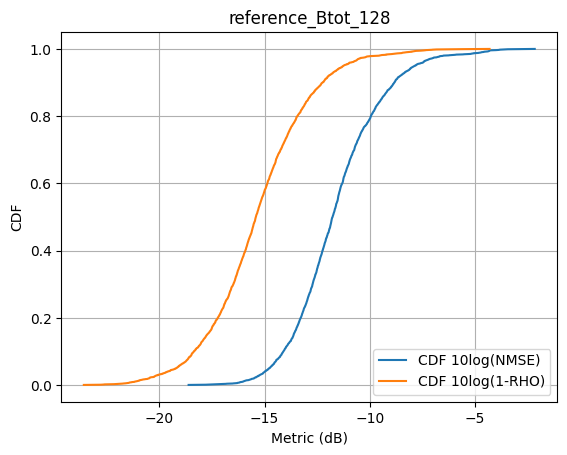

In [1]:
# import utils
# import matlab.engine
# import dataclasses
# import runner
# import reference_impl
# 
# cfg = utils.Config(
#     num_rx_antennas=1,
#     num_tx_antennas=32,
#     num_subcarriers=80,
#     train_test_split=0.8,
#     data_root="../data/dataset2",
#     reduce_pca_overhead=False,
#     epochs=10,
#     compression_rate_dct=0.6,
#     predictor_window_size = 5,
#     total_bits=512,
#     results_save_path="../results",
#     compressor_type="kmeans",
#     preprocessor_type="real_imag",
#     trunc_lstm_pred=20
#     # duplicate_data=1,
#     # data_snr=-1
# )
# 
# matlab = matlab.engine.start_matlab()
# possible_bits = [128]
# 
# for btot in possible_bits:
#     this_cfg = dataclasses.replace(cfg, total_bits=btot)
# 
#     # runner.run_model(
#     #     this_cfg,
#     #     matlab,
#     #     reference_impl.FullReferenceModel,
#     #     "reference"
#     # )
#     
#     runner.run_reference_model(
#         this_cfg,
#         matlab,
#         reference_impl.FullReferenceModel,
#         "reference"
#     )



Running Model lstm_pca40, btot 128, pred_size 5
This is the LSTM
Fitting the PCA
Fitting the LSTM
Training k-means clustering...
Considering bTot: 100


  0%|          | 0/7 [00:00<?, ?it/s]

Predicted zdl: (3076, 40)
Predicted zdl: (3076, 40)
ul_pred_error: (3076, 40)
Assessing performance...
Plotting results...


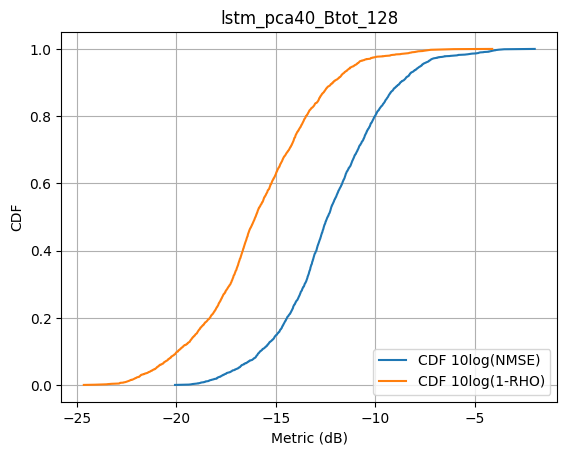

Test for lstm_pca40 128 complete!
Running Model lstm_pca80, btot 128, pred_size 5
This is the LSTM
Fitting the PCA
Fitting the LSTM
Training k-means clustering...
Considering bTot: 100


  0%|          | 0/7 [00:00<?, ?it/s]

Predicted zdl: (3076, 80)
Predicted zdl: (3076, 80)
ul_pred_error: (3076, 80)
Assessing performance...
Plotting results...


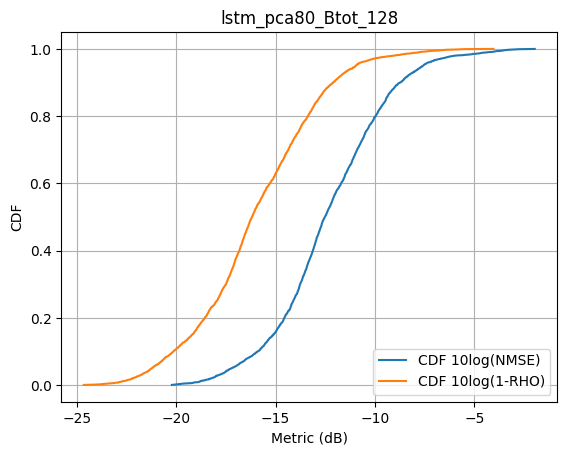

Test for lstm_pca80 128 complete!
Running Model lstm_pca160, btot 128, pred_size 5
This is the LSTM
Fitting the PCA
Fitting the LSTM
Training k-means clustering...
Considering bTot: 100


  0%|          | 0/7 [00:00<?, ?it/s]

Predicted zdl: (3076, 160)
Predicted zdl: (3076, 160)
ul_pred_error: (3076, 160)
Assessing performance...
Plotting results...


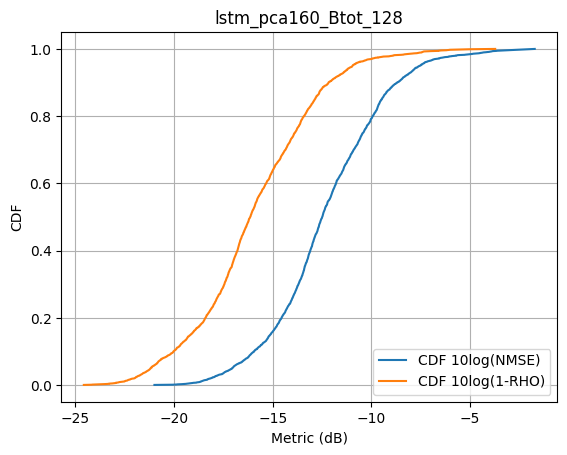

Test for lstm_pca160 128 complete!
Running Model lstm_pca320, btot 128, pred_size 5
This is the LSTM
Fitting the PCA
Fitting the LSTM
Training k-means clustering...
Considering bTot: 100


  0%|          | 0/7 [00:00<?, ?it/s]

Predicted zdl: (3076, 320)
Predicted zdl: (3076, 320)
ul_pred_error: (3076, 320)
Assessing performance...
Plotting results...


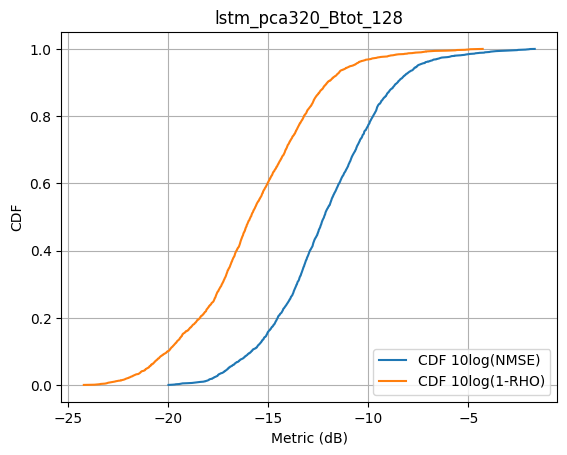

Test for lstm_pca320 128 complete!


In [8]:

cfg = utils.Config(
    num_rx_antennas=1,
    num_tx_antennas=32,
    num_subcarriers=80,
    train_test_split=0.8,
    data_root="../data/dataset2",
    reduce_pca_overhead=False,
    epochs=10,
    compression_rate_dct=0.6,
    predictor_window_size = 5,
    total_bits=128,
    results_save_path="../results",
    compressor_type="kmeans",
    preprocessor_type="real_imag",
    trunc_lstm_pred=20,
    max_pca_coeffs=200
    # duplicate_data=1,
    # data_snr=-1
)

for pcas in [40, 80, 160, 320]:
    this_cfg = dataclasses.replace(cfg, max_pca_coeffs=pcas)

    runner.run_model(
        this_cfg,
        matlab,
        lstm_model.FullLSTMModel,
        f"lstm_pca{pcas}",
        # simulation=True
    )


Running Model onehist, btot 128, pred_size 1
This is the History Model
Fitting the PCA
Fitting the LSTM
Training k-means clustering...
Considering bTot: 100


  0%|          | 0/7 [00:00<?, ?it/s]

Predicted zdl: (3084, 200)
Predicted zdl: (3084, 200)
ul_pred_error: (3084, 200)
Assessing performance...
Plotting results...


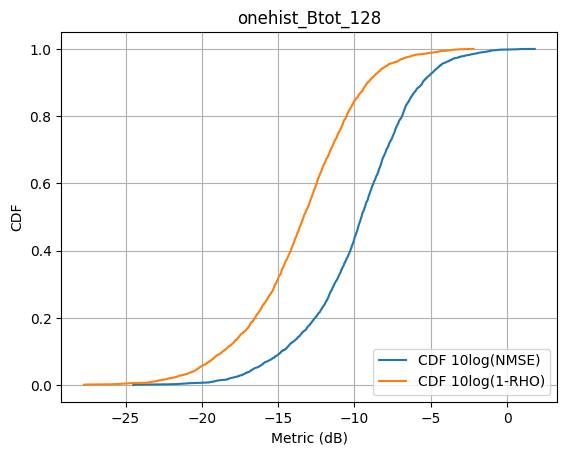

Test for onehist 128 complete!
Running Model fiveavghist, btot 128, pred_size 5
This is the History Model
Fitting the PCA
Fitting the LSTM
Training k-means clustering...
Considering bTot: 100


  0%|          | 0/7 [00:00<?, ?it/s]

Predicted zdl: (3076, 200)
Predicted zdl: (3076, 200)
ul_pred_error: (3076, 200)
Assessing performance...
Plotting results...


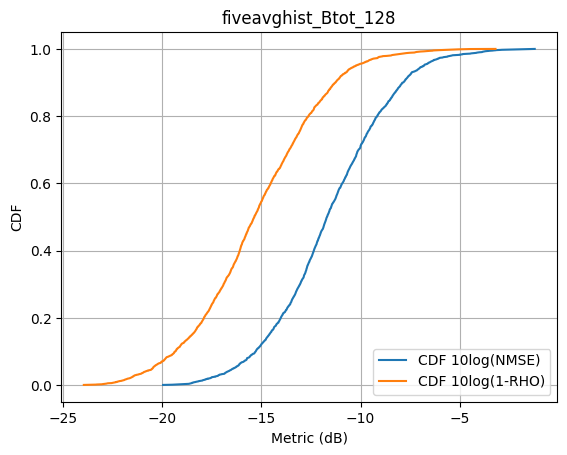

Test for fiveavghist 128 complete!
Running Model lstm_pca200, btot 128, pred_size 5
This is the LSTM
Fitting the PCA
Fitting the LSTM


/Users/dziper/opt/anaconda3/envs/csi/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training k-means clustering...
Considering bTot: 100


  0%|          | 0/7 [00:00<?, ?it/s]

Predicted zdl: (3076, 200)
Predicted zdl: (3076, 200)
ul_pred_error: (3076, 200)
Assessing performance...
Plotting results...


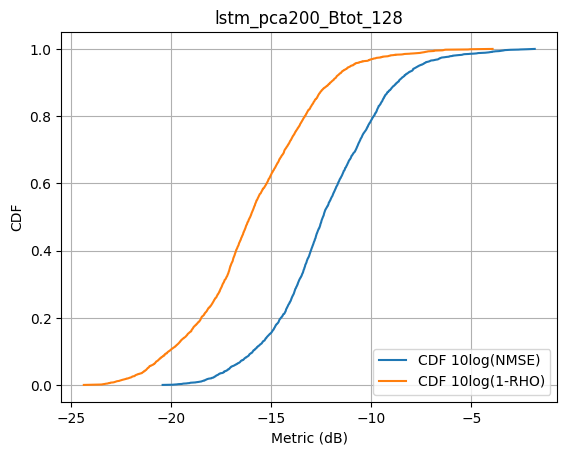

Test for lstm_pca200 128 complete!
Training k-means clustering...
Considering bTot: 100


  0%|          | 0/7 [00:00<?, ?it/s]

Assessing performance...
Plotting results...


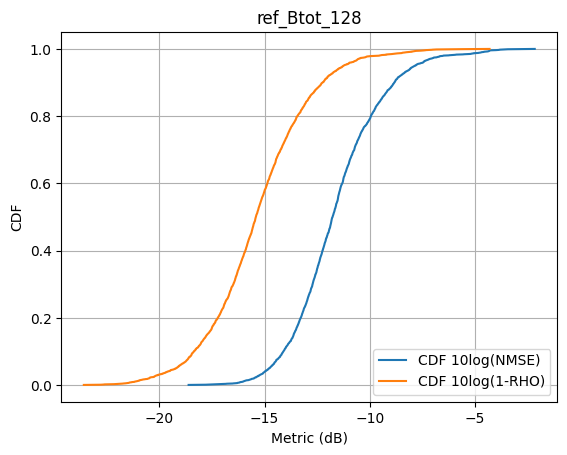

In [3]:

this_cfg = utils.Config(
    num_rx_antennas=1,
    num_tx_antennas=32,
    num_subcarriers=80,
    train_test_split=0.8,
    data_root="../data/dataset2",
    reduce_pca_overhead=False,
    epochs=10,
    compression_rate_dct=0.6,
    predictor_window_size = 5,
    total_bits=128,
    results_save_path="../results",
    compressor_type="kmeans",
    preprocessor_type="real_imag",
    trunc_lstm_pred=20,
    max_pca_coeffs=200
    # duplicate_data=1,
    # data_snr=-1
)

matlab = matlab.engine.start_matlab()
this_cfg = dataclasses.replace(this_cfg, predictor_window_size=1)
runner.run_model(
    this_cfg,
    matlab,
    lstm_model.SimpleHistoryModel,
    f"onehist",
    # simulation=True
)

this_cfg = dataclasses.replace(this_cfg, predictor_window_size=5)
runner.run_model(
    this_cfg,
    matlab,
    lstm_model.SimpleHistoryModel,
    f"fiveavghist",
    # simulation=True
)

runner.run_model(
    this_cfg,
    matlab,
    lstm_model.FullLSTMModel,
    f"lstm_pca{this_cfg.max_pca_coeffs}",
    # simulation=True
)

this_cfg = dataclasses.replace(this_cfg, max_pca_coeffs=500, predictor_window_size=5)
runner.run_reference_model(
    this_cfg,
    matlab,
    reference_impl.FullReferenceModel,
    f"ref",
    # simulation=True
)
